In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
from tensorflow import keras
import keras
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igorm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\igorm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
#Ver como o dado foi armazenado
data = pd.read_json('./News_Category_Dataset_v3.json', lines=True)
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [6]:
#data.info()
data.describe()

,date
count,209527
mean,2015-04-30 00:44:14.344308736
min,2012-01-28 00:00:00
25%,2013-08-10 00:00:00
50%,2015-03-16 00:00:00
75%,2016-11-01 00:00:00
max,2022-09-23 00:00:00


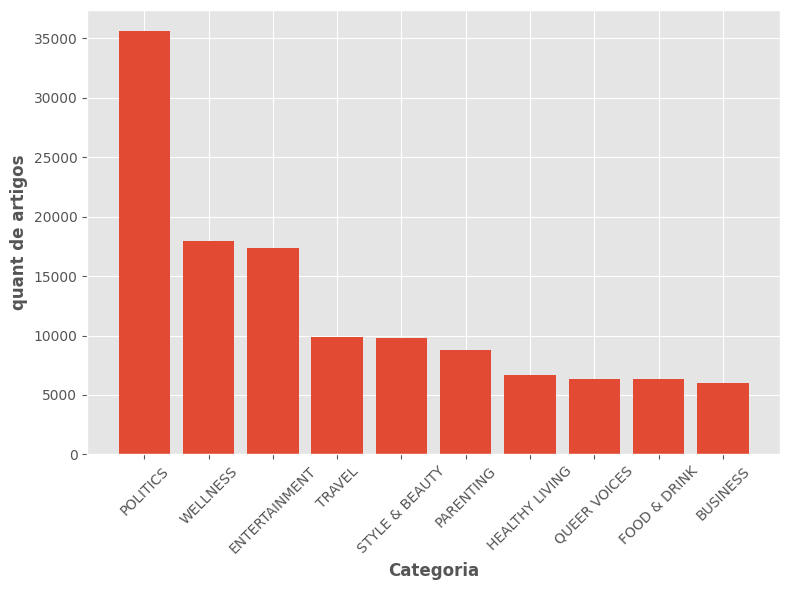

In [7]:
#Analisar as categorias dos artigos
category_counts = data.category.value_counts()

plt.figure(figsize=(8,6))
plt.bar(category_counts.index[:10], category_counts.values[:10])
plt.xlabel('Categoria')
plt.ylabel('quant de artigos')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

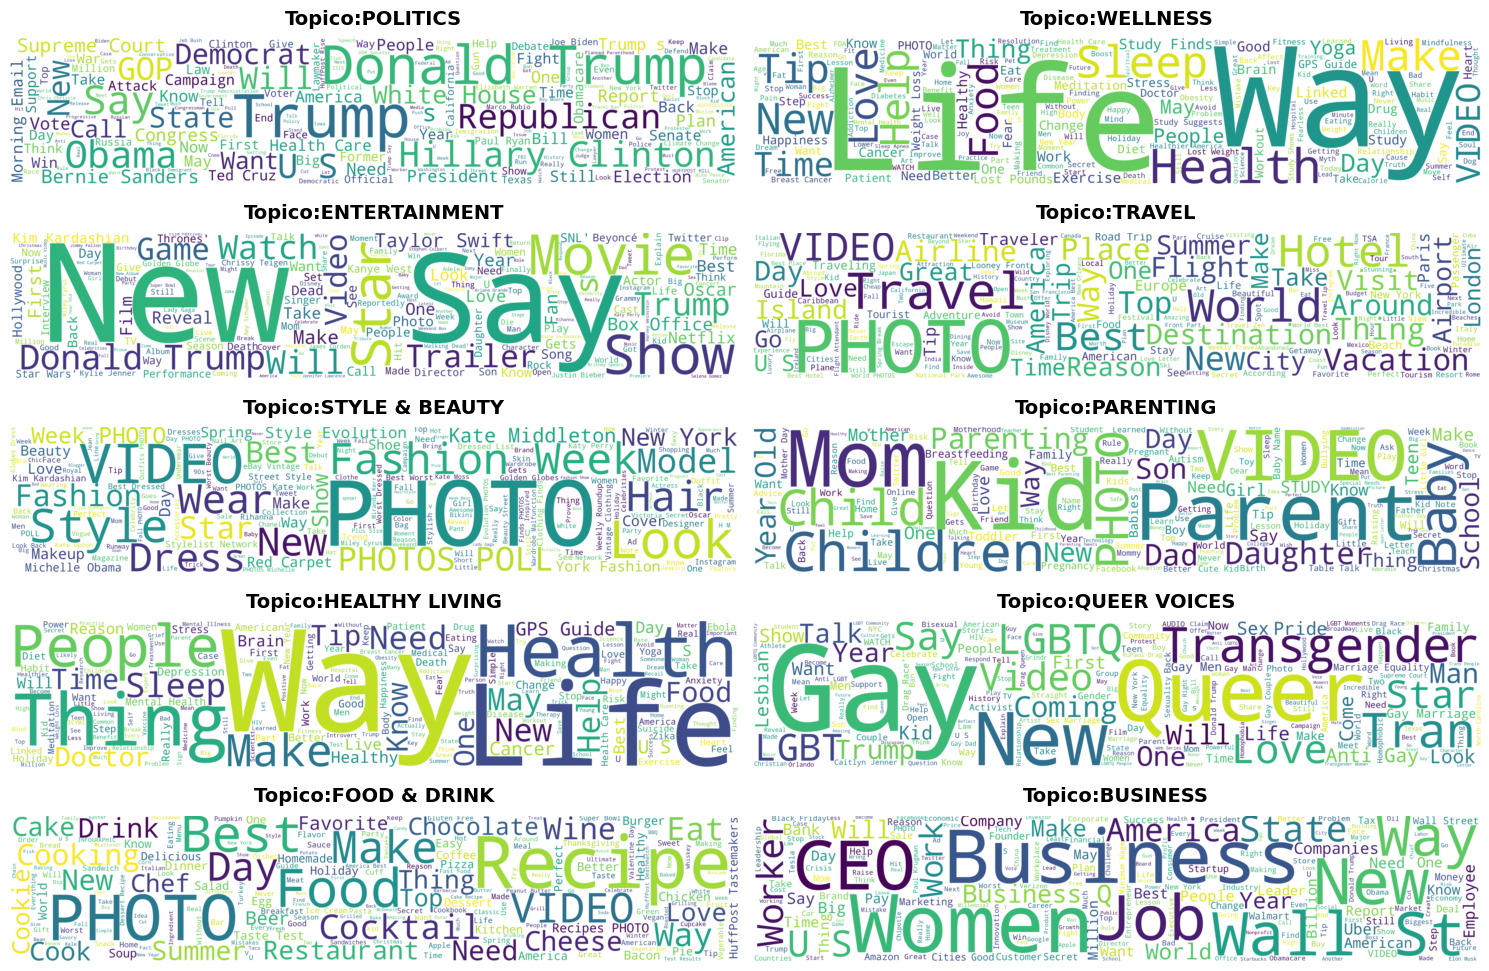

In [8]:
def create_wordcloud(category, text_column, ax):
    words = " ".join(data[data["category"] == category][text_column])
    wordcloud = WordCloud(width=4000, height=800, background_color="white").generate(words)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f'Topico:{category}')
    ax.axis("off")

#  Get the top 10 categories efficiently
top_categories = data["category"].value_counts().head(10).index.to_list()

# Create figure and subplots (adjust nrows, ncols as needed)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))

# Iterate and plot using the top categories
for i, category in enumerate(top_categories):
    ax = axes.flat[i]
    create_wordcloud(category, "headline", ax)

plt.tight_layout()
plt.show()

# Processando os dados

In [4]:
# start with removing some data from politics dataframe ndf
politics_list = (data[data['category'] == 'POLITICS'].index).to_list()
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

# drop these 16000 labels from the dataset
data_2 = data.copy()
data_2.drop(list_16, axis=0, inplace=True)

In [5]:


def preprocess_text(text):
    """
    Preprocesses text data for improved categorization.

    Args:
        text (str): The text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """

    # Letras minúsculas para não diferenciar maiúsculas de minúsculas
    text = text.lower()
    
    # Remove espaços em branco extras (incluindo vários espaços)
    text = re.sub(r'\s+', ' ', text)

    # Remove URLs 
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)

    # Remove usernames 
    text = re.compile(r"(?i)@[a-z0-9_]+").sub('', text)

    # Remove HTML tags 
    text = re.sub(r"\[[^()]*\]", "", text)

    # Remove non-alphanumeric characters 
    text = re.sub(r"[^\w\s]", "", text)  

    # Remove stopwords 
    stop_words = nltk.corpus.stopwords.words('english') 
    text = [word for word in text.split() if word not in stop_words]

    # Lemmatization (optional but can improve accuracy)
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]

    return ' '.join(text)


In [6]:
print("Texto antes do pre-processing:\n",data_2['headline'][0])
print("---"*35)
print("Texto depois do pre-processing:\n",preprocess_text(data_2['headline'][0]))

Texto antes do pre-processing:
 Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters
---------------------------------------------------------------------------------------------------------
Texto depois do pre-processing:
 4 million american roll sleeve omicrontargeted covid booster


In [7]:
#fazendo alteracoes na database
data_3 = data_2.copy()
data_3.drop(columns=['authors'], inplace=True)
data_3.drop(columns=['link'], inplace=True)
data_3.drop(columns=['date'], inplace=True)

data_3['headline'] = data_3['headline'].apply(preprocess_text)




In [13]:
#Checar o antes e o depois da quantidade de palavras
old_len = data_2['headline'].apply(lambda x: len([i for i in x.split()])).sum()
new_len = data_3['headline'].apply(lambda x: len([i for i in x.split()])).sum()

print(f'Antes: {old_len}')
print(f'Depois: {new_len}')


Antes: 1840505
Depois: 1294940


# Tokenização e vetorização dos dados
### Refazendo o pre precessamento


In [11]:

""" O preprocessamento anterior foi para demostrar a diferença e a necessidade de realizar essa preparação dos dados, 
só que existem melhorias a serem feitas"""

data_final = data_2.copy()
"""
Colunas suas utilidades no projeto
1- link -> No momento não será utilizado
2- headline -> Titulo da noticia, sera utilizado para a análise
3-category -> Categoria da noticia, sera utilizado para a análise 
4- short_description -> Descrição curta da noticia, sera utilizado para a análise
5- authors -> No momento não será utilizado
6- date -> No momento não será utilizado
"""

data_final = data_final.drop(['link', 'authors', 'date'], axis=1)

data_final.head()



,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def enhanced_clean(text):
  # Step 1: Lowercase for case-insensitivity
  text = text.lower()
  # Convert all characters to lowercase for consistent analysis.

  # Step 2: Efficient Regular Expression Cleaning
  text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*|[^\w\s]|[\[\]])", "", text)
  # This removes unwanted elements like usernames, hashtags, URLs, punctuation, and bracketed text.

  # Step 3: Remove Extra Whitespace
  text = re.sub(r'\s+', ' ', text)
  # Replace sequences of whitespace with a single space.

  # Step 4: Tokenization Considering Numbers and Words (Improved)
  token_pattern = r"(?u)\b\w+\b|\b\d{1,}\b|\w+[\w\'\-]*\w+"
  tokens = re.findall(token_pattern, text)
  # This splits the text into tokens (words) using an improved regular expression:
  # - Grabs word characters with word boundaries (`\b\w+\b`) for complete words.
  # - Captures sequences of digits (`\b\d{1,}\b`) as single tokens using word boundaries and requiring at least one digit (`{1,}`). This ensures multi-digit numbers like "23" are treated as a whole.
  # - Considers hyphenated words and apostrophes (`\w+[\w\'\-]*\w+`) with the `(?u)` flag for unicode compatibility.

  # Step 5: Stop Word Removal and Lemmatization (Optional)
  stop_words = stopwords.words("english")
  lemmatizer = WordNetLemmatizer()
  cleaned_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
  # This part is optional. It removes stop words and lemmatizes remaining tokens.

  # Step 6: Join Cleaned Tokens and Fix Number-Word Combinations
  cleaned_text = " ".join(cleaned_tokens)
  # Loop through tokens (words) after splitting the cleaned text
  for i in range(len(cleaned_text.split()) - 1):
    # Check if current token is a digit and the next one is alphabetic (letter)
    if cleaned_text.split()[i].isdigit() and cleaned_text.split()[i+1].isalpha():
      # If number-word combination found, insert a space between them
      cleaned_text = cleaned_text[:i+1] + " " + cleaned_text[i+1:]

  return cleaned_text



data_final_cleaned = data_final.copy()
data_final_cleaned= data_final_cleaned.drop(['short_description', 'category'], axis=1)


data_final_cleaned['headline'] = data_final_cleaned['headline'].apply(enhanced_clean)

#vaderSentiment
analyzer = SentimentIntensityAnalyzer()
for index, row in data_final_cleaned.iterrows():
    sentiment = analyzer.polarity_scores(row['headline'])
    if sentiment['compound'] > 0.05:
        data_final_cleaned.loc[index, 'predicted_sentiment_lexicon'] = 'positive'
    elif sentiment['compound'] < -0.05:
        data_final_cleaned.loc[index, 'predicted_sentiment_lexicon'] = 'negative'
    else:
        data_final_cleaned.loc[index, 'predicted_sentiment_lexicon'] = 'neutral'


#data_final['short_description'] = data_final['short_description'].apply(data_cleaning)

data_final_cleaned.head(10)


,headline,predicted_sentiment_lexicon
0,4 million americans roll sleeves omicrontarge...,neutral
1,american airlines flyer charge ban life punch ...,negative
2,2 3 funniest tweet cat dog week sept 1723,positive
3,funniest tweet parent week sept 1723,positive
4,woman call cop black birdwatcher lose lawsuit ...,negative


In [22]:
for x in range(10):
    print(data_final_cleaned['headline'][x] + ' ---> ' + data_final_cleaned['predicted_sentiment_lexicon'][x])

4  million americans roll sleeves omicrontargeted covid boosters ---> neutral
american airlines flyer charge ban life punch flight attendant video ---> negative
2  3 funniest tweet cat dog week sept 1723 ---> positive
funniest tweet parent week sept 1723 ---> positive
woman call cop black birdwatcher lose lawsuit exemployer ---> negative
clean  er dead belk bathroom 4 days body find police ---> negative
reporter get adorable surprise boyfriend live tv ---> positive
puerto ricans desperate water hurricane fionas rampage ---> negative
new documentary capture complexity child immigrants ---> neutral
biden un call russian war affront body charter ---> negative


In [17]:
# Vectorization 

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#TF-IDF
def using_TF_IDF(X_train, X_test):

    X_vector =[]

    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_vector.append(X_train_vectorized)
    X_test_vectorized = vectorizer.fit_transform(X_test)
    X_vector.append(X_test_vectorized)

    return X_vector


#Usando keras para word embedding
def using_keras_word_embedding(X_train, X_test):

    X_vector = []

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    sequence_train = tokenizer.text_to_sequences(X_train)
    sequence_test = tokenizer.text_to_sequences(X_test) 

    padded_train = pad_sequences(sequence_train, maxlen=100)
    X_vector.append(padded_train)
    padded_test = pad_sequences(sequence_test, maxlen=100)
    X_vector.append(padded_test)

    return X_vector


    


In [22]:
# Usando o modelo SVM de Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def svm_model(data_final_cleaned):
    text = data_final_cleaned['headline']
    data_final_cleaned['sentiment'] = pd.Series(dtype='object')

    X_train, X_test, y_train, y_test = train_test_split(text, data_final_cleaned['sentiment'], test_size=0.2, random_state=42)

    x = using_TF_IDF(X_train, X_test)

    X_train_vectorized = x[0]
    X_test_vectorized = x[1]

    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_vectorized, y_train)

    y_pred = svm_model.predict(X_test_vectorized)

    # Update sentiment column with predicted labels
    sentiment_mapping = {0: "negative", 1: "positive", 2: "neutral"}  # Adjust mapping as needed
    data_final_cleaned.loc[X_test.index, 'sentiment'] = y_pred.astype(int).map(sentiment_mapping)

    # No need to return accuracy here (optional)
    # accuracy = accuracy_score(y_test, y_pred)
    # print(f"Precisão:{accuracy}")

svm_model(data_final_cleaned)

ValueError: Input contains NaN